In [1]:
import csv
from matplotlib import pyplot as plt
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.data import random_split

from network import ConvNN
from custom_dataset import CustomDataset

# Running on GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
transform = transforms.Compose(
    [
        # transforms.RandomHorizontalFlip(p=0.25),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ]
)

def label_transform(label):
    if label == 'open': 
        return 0
    elif label == 'sunglasses':
        return 1
    else:
        raise ValueError('Invalid label')

# Create Datasets for training and testing
train_dataset = CustomDataset(
    data_dir = './resource/train',
    label_dir = './resource/train_tags.csv',
    data_mode = "train",
    transform = transform,
    label_transform = label_transform
)

test_dataset = CustomDataset(
    data_dir = './resource/test',
    label_dir = None,
    data_mode = "test",
    transform = transform
)

In [3]:
total_train_samples = len(train_dataset)
val_size = int(total_train_samples * 0.2)
train_size = total_train_samples - val_size

# Split the data set
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Create DataLoader for training and validation
train_loader = DataLoader(dataset=train_subset, batch_size=1, shuffle=True)
val_loader = DataLoader(dataset=val_subset, batch_size=15, shuffle=False)

In [4]:
cnn = ConvNN().to(device)

# Define loss function and optimizer
epoch_iter = 40
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.002, weight_decay=2e-6)
print(f'Epoch\ttrain_Loss\tval_Loss\ttrain_Acc\tval_acc')

avg_train_loss_list = []
train_accuracy_list = []
avg_val_loss_list = []
val_accuracy_list = []

for epoch in range(epoch_iter):
    # Training model
    cnn.train()
    train_running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(train_loader, 0):
        # Get input data
        inputs, labels = data
        # Gradient zero
        optimizer.zero_grad()
        # Forward + Backward + Optimize
        outputs = cnn(inputs)
        train_loss = criterion(outputs, labels)
        train_loss.backward()
        optimizer.step()
        train_running_loss += train_loss.item()
        # Calculate accurate count and total count
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    # Calculate the loss and accuracy on train_set
    avg_train_loss = train_running_loss / train_size * train_loader.batch_size
    avg_train_loss_list.append(avg_train_loss)
    train_accuracy = correct / total
    train_accuracy_list.append(train_accuracy)

    # Verify on the validation set
    cnn.eval()
    val_running_loss = 0
    correct = 0
    total = 0
    # Disable the Gradient
    with torch.no_grad():
        for data in val_loader:
            # Get input data
            images, labels = data
            # Forward
            outputs = cnn(images)
            val_loss = criterion(outputs, labels)
            val_running_loss += val_loss.item()
            # Calculate accurate count and total count
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()      
    # Calculate the loss and accuracy on val_set
    avg_val_loss = val_running_loss / val_size * val_loader.batch_size
    avg_val_loss_list.append(avg_val_loss)
    val_accuracy = correct / total
    val_accuracy_list.append(val_accuracy)

    # Print statistics
    print(f'{epoch + 1}\t{avg_train_loss:.3f}\t\t{avg_val_loss:.3f}\t\t{train_accuracy:.3f}\t\t{val_accuracy:.3f}')


Epoch	train_Loss	val_Loss	train_Acc	val_acc
1	0.689		0.661		0.551		0.760
2	0.564		0.573		0.739		0.720
3	0.475		0.470		0.855		0.827
4	0.420		0.444		0.901		0.840
5	0.407		0.401		0.911		0.920
6	0.377		0.416		0.941		0.907
7	0.370		0.385		0.950		0.920
8	0.368		0.359		0.950		0.947
9	0.370		0.399		0.950		0.933
10	0.358		0.363		0.960		0.933
11	0.345		0.347		0.974		0.973
12	0.349		0.364		0.964		0.947
13	0.332		0.345		0.987		0.973
14	0.346		0.345		0.967		0.960
15	0.350		0.376		0.964		0.947
16	0.342		0.330		0.970		0.987
17	0.333		0.343		0.983		0.973
18	0.336		0.337		0.977		0.973
19	0.338		0.338		0.974		0.960
20	0.344		0.345		0.967		0.973
21	0.335		0.353		0.980		0.960
22	0.342		0.347		0.970		0.960
23	0.332		0.340		0.983		0.973
24	0.327		0.328		0.990		0.987
25	0.324		0.328		0.990		0.987
26	0.328		0.338		0.987		0.973
27	0.331		0.347		0.980		0.960
28	0.322		0.340		0.993		0.973
29	0.324		0.350		0.987		0.960
30	0.330		0.396		0.987		0.907
31	0.332		0.345		0.983		0.973
32	0.329		0.342		0.983		0.973
33	0.

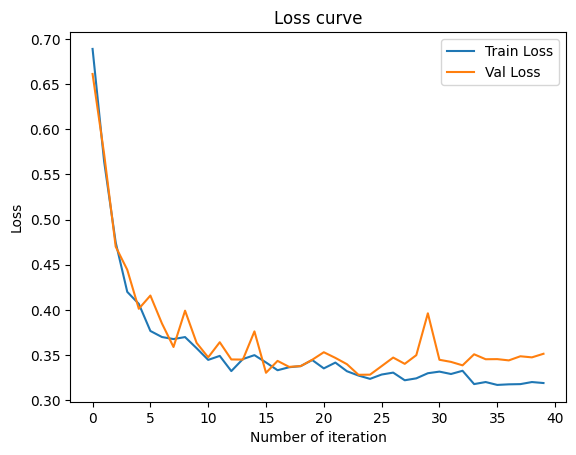

In [5]:
# Show the Loss curve
plt.plot(range(epoch_iter), avg_train_loss_list, label = "Train Loss")
plt.plot(range(epoch_iter), avg_val_loss_list, label = "Val Loss")

plt.legend()
plt.title("Loss curve")
plt.xlabel("Number of iteration")
plt.ylabel("Loss")

plt.show()

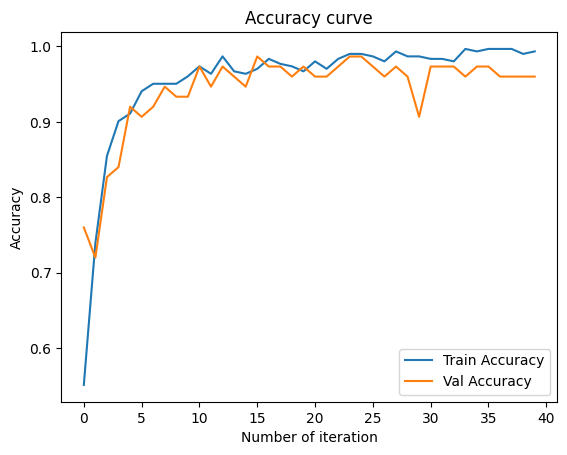

In [6]:
# Show the Accuracy curve
plt.plot(range(epoch_iter), train_accuracy_list, label = "Train Accuracy")
plt.plot(range(epoch_iter), val_accuracy_list, label = "Val Accuracy")

plt.legend()
plt.title("Accuracy curve")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")

plt.show()

In [8]:
# Create DataLoader for training
train_loader = DataLoader(dataset=train_dataset, batch_size=1, shuffle=True)

cnn = ConvNN().to(device)

# Define loss function and optimizer
epoch_iter = 60
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.002, weight_decay=1e-4)
print(f'Epoch\ttrain_Loss\tval_Loss')

avg_train_loss_list = []
train_accuracy_list = []
avg_val_loss_list = []
val_accuracy_list = []

for epoch in range(epoch_iter):
    # Training model
    cnn.train()
    train_running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(train_loader, 0):
        # Get input data
        inputs, labels = data
        # Gradient zero
        optimizer.zero_grad()
        # Forward + Backward + Optimize
        outputs = cnn(inputs)
        train_loss = criterion(outputs, labels)
        train_loss.backward()
        optimizer.step()
        train_running_loss += train_loss.item()
        # Calculate accurate count and total count
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    # Calculate the loss and accuracy on train_set
    avg_train_loss = train_running_loss / train_size * train_loader.batch_size
    avg_train_loss_list.append(avg_train_loss)
    train_accuracy = correct / total
    train_accuracy_list.append(train_accuracy)

    # Print statistics
    print(f'{epoch + 1}\t{avg_train_loss:.3f}\t\t{train_accuracy:.3f}')

Epoch	train_Loss	val_Loss
1	0.858		0.508
2	0.669		0.778
3	0.568		0.868
4	0.533		0.897
5	0.479		0.934
6	0.461		0.952
7	0.450		0.958
8	0.449		0.960
9	0.441		0.963
10	0.435		0.963
11	0.435		0.966
12	0.416		0.984
13	0.414		0.989
14	0.409		0.989
15	0.407		0.989
16	0.407		0.989
17	0.399		0.995
18	0.403		0.992
19	0.418		0.979
20	0.428		0.971
21	0.408		0.987
22	0.398		0.995
23	0.407		0.992
24	0.409		0.987
25	0.393		1.000
26	0.404		0.992
27	0.399		0.995
28	0.398		0.997
29	0.408		0.987
30	0.407		0.989
31	0.410		0.984
32	0.403		0.989
33	0.392		1.000
34	0.402		0.992
35	0.419		0.974
36	0.398		0.995
37	0.402		0.992
38	0.395		1.000
39	0.403		0.989
40	0.417		0.981
41	0.395		0.997
42	0.397		0.995
43	0.392		1.000
44	0.392		1.000
45	0.398		0.995
46	0.406		0.989
47	0.395		0.995
48	0.411		0.984
49	0.399		0.995
50	0.395		0.997
51	0.393		0.997
52	0.392		1.000
53	0.394		0.997
54	0.395		0.997
55	0.400		0.992
56	0.394		0.997
57	0.395		0.995
58	0.395		0.997
59	0.405		0.987
60	0.404		0.989


In [9]:
# save the model
torch.save(cnn.state_dict(), './model/cnn_state_dict.pth')

In [10]:
# Set to evaluation mode
cnn.eval()  
test_loader = DataLoader(dataset=test_dataset, shuffle=False)

# Open a new CSV file for writing
with open('./result/predictions.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['id', 'result'])

    with torch.no_grad():  # Disable the Gradient
        for inputs, labels in test_loader:
            outputs = cnn(inputs)
            _, predicted = torch.max(outputs, 1)  # Get the most probable prediction result

            # Iterate over each sample in the batch
            for label, prediction in zip(labels, predicted):
                writer.writerow([label, prediction.item()])
